In [41]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from pylab import *

%matplotlib inline

from pandas import DataFrame

In [55]:
from sklearn import linear_model, cross_validation
from math import sqrt

In [18]:
df = pd.read_csv("energy_efficiency.csv")
df.head()
df.tail()
df.describe()

#X1=Relative Compactness 
#X2=Surface Area 
#X3=Wall Area 
#X4=Roof Area 
#X5=Overall Height 
#X6=Orientation 
#X7=Glazing Area 
#X8=Glazing Area Distribution 

#y1=Heating Load 
#y2=Cooling Load

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,Unnamed: 10,Unnamed: 11
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000,0.0,0.0
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760,NaN,NaN
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306,NaN,NaN
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000,NaN,NaN
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000,NaN,NaN
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000,NaN,NaN
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500,NaN,NaN
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000,NaN,NaN


In [20]:
col=[10,11]
df.drop(df.columns[col], axis=1, inplace=True)
df.head()
df.dropna(how="all", inplace=True)

#We can see clearly X1-8 are attributes and Y1-2 are labels

In [21]:
#STATISTICAL SUMMARY - understanding attributes

summary = df.describe()
summary

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


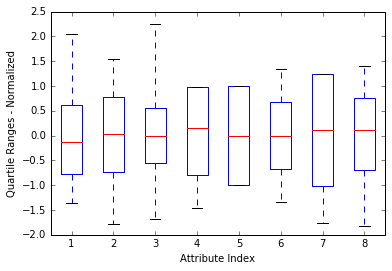

In [36]:
#normalization

df_normalized = DataFrame.copy(df)
df_normalized.drop(["Y1", "Y2"], axis=1, inplace=True)
ncols = len(df_normalized.columns)

for i in range(ncols):
    mean = summary.iloc[1,i]
    std = summary.iloc[2,i]
    df_normalized.iloc[:,i:(i + 1)] = (df_normalized.iloc[:,i:(i + 1)]  - mean)/ std

array = df_normalized.values
plt.boxplot(array)
plt.xlabel("Attribute Index")
plt.ylabel("Quartile Ranges - Normalized")

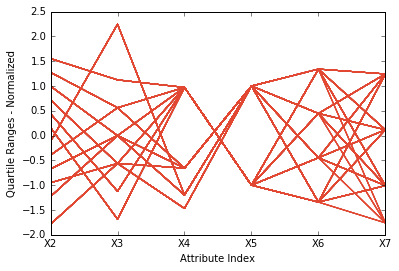

In [37]:
#parallel coordinate

nDataCols = len(df_normalized.columns) - 1

for i in range(len(df_normalized.index)):
    dataRow = df_normalized.iloc[i, 1:nDataCols]
    normTarget = df_normalized.iloc[1, nDataCols]
    labelColor = 1.0 / (1.0 + exp(-normTarget))
    dataRow.plot(color=plt.cm.RdYlBu(labelColor), alpha =0.5)
    
plt.xlabel("Attribute Index")
plt.ylabel("Quartile Ranges - Normalized")



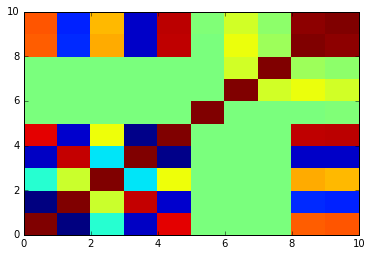

In [40]:
corMatrix = DataFrame(df.corr())
plt.pcolor(corMatrix)

In [64]:
#FORWARD STEPWISE REGRESSION - CONTROLLING OVERFITTING

def xattrSelect(x, idxSet):
    xOut = []
    for row in x:
        xOut.append([row[i] for i in idxSet])
    return(xOut)

yCols = [8,9]

X = df.drop(["Y1", "Y2"], axis=1)
X = np.array(X)

y = df[["Y1", "Y2"]]
y = np.array(y)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.1)

#getting attribute as a list, one at a time, starting with empty attribute

attributeList = []
index = range(len(X[1]))
indexSet = set(index)
indexSeq = []
oosError = []

for i in index:
    attSet = set(attributeList)
    attTrySet = indexSet - attSet
    attTry = [ii for ii in attTrySet]
    errorList = []
    attTemp = []
    for iTry in attTry:
        attTemp = [] + attributeList
        attTemp.append(iTry)
        xTrainTemp = xattrSelect(X_train, attTemp)
        xTestTemp = xattrSelect(X_test, attTemp)
        xTrain = np.array(xTrainTemp)
        yTrain = np.array(y_train)
        xTest = np.array(xTestTemp)
        yTest = np.array(y_test)
        
        clf = linear_model.LinearRegression()
        clf.fit(xTrain,yTrain)
        
        rmsError = np.linalg.norm((yTest-clf.predict(xTest)),2)/sqrt(len(yTest))
        errorList.append(rmsError)
        attTemp = []
    
    iBest = np.argmin(errorList)
    attributeList.append(attTry[iBest])
    oosError.append(errorList[iBest])
    
print("Out of sample error versus attribute set size" )
print(oosError)
print("\n" + "Best attribute indices")
print(attributeList)

names = list(df.columns.values)

namesList = [names[i] for i in attributeList]
print("\n" + "Best attribute names")
print(namesList)    
        


Out of sample error versus attribute set size
[6.0381300703972558, 4.9579385464450061, 4.2868079985443979, 4.2786619693728101, 4.3027229470962434, 4.3285018650161549, 4.2669438541171312, 4.2643665359685281]

Best attribute indices
[4, 6, 0, 7, 5, 3, 2, 1]

Best attribute names
['X5', 'X7', 'X1', 'X8', 'X6', 'X4', 'X3', 'X2']


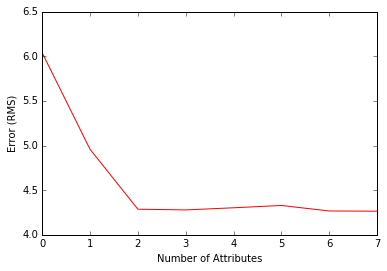

In [65]:
#plot error vs number of attributes

x = range(len(oosError))
plt.plot(x, oosError, 'r')
plt.xlabel("Number of Attributes")
plt.ylabel("Error (RMS)") #root mean square

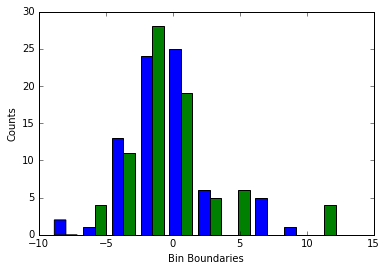

In [69]:
indexBest = oosError.index(min(oosError))
attributesBest = attributeList[1:(indexBest + 1)]

xTrainTemp = xattrSelect(X_train, attributesBest)
xTestTemp = xattrSelect(X_test, attributesBest)
xTrain,xTest = np.array(xTrainTemp), np.array(xTestTemp)

clf.fit(xTrain, yTrain)
errorVector = yTest-clf.predict(xTest)
plt.hist(errorVector)
plt.xlabel("Bin Boundaries")
plt.ylabel("Counts")

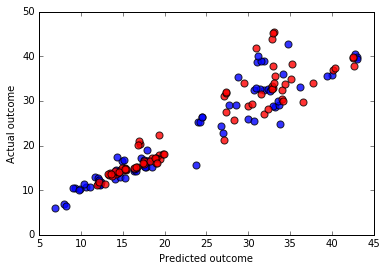

In [80]:
# predicted = clf.predict(xTest)
# predicted
plt.scatter(clf.predict(xTest)[:,0], yTest[:,0], s=50,c = 'b', alpha=0.8)
plt.scatter(clf.predict(xTest)[:,1], yTest[:,1], s=50, c='r', alpha=0.8)
plt.xlabel("Predicted outcome")
plt.ylabel("Actual outcome")

RMS Error:  5.49884536255 alpha:  1.0
RMS Error:  4.97859611662 alpha:  0.1
RMS Error:  4.73651607995 alpha:  0.010000000000000002
RMS Error:  4.71577200121 alpha:  0.0010000000000000002
RMS Error:  4.71396348795 alpha:  0.00010000000000000002
RMS Error:  4.71378588081 alpha:  1.0000000000000003e-05
RMS Error:  4.7137681532 alpha:  1.0000000000000004e-06


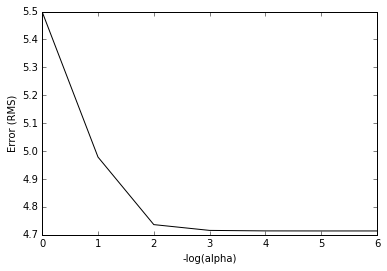

In [83]:
#RIDGE REGRESSION

alphaList =[0.1**i for i in [0,1,2,3,4,5,6]]
rmsError = []

for a in alphaList:
    clf2 = linear_model.Ridge(alpha=a)
    clf2.fit(xTrain, yTrain)
    rmsError.append(np.linalg.norm((yTest - clf2.predict(xTest)), 2) / sqrt(len(yTest)))
    
for i in range(len(rmsError)):
    print("RMS Error: ", rmsError[i], "alpha: ", alphaList[i])    
    
x = range(len(rmsError))
plt.plot(x, rmsError, 'k')
plt.xlabel('-log(alpha)')
plt.ylabel('Error (RMS)')

    

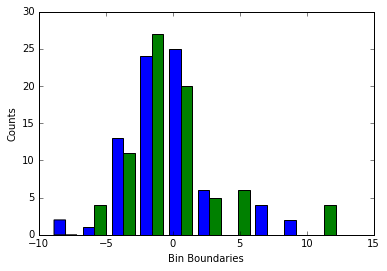

In [86]:
#plot histagram and scatter plot using the best alpha value

indexBest = rmsError.index(min(rmsError))
alph = alphaList[indexBest]
clf3 = linear_model.Ridge(alpha=alph)
clf3.fit(xTrain, yTrain)
errorVector = yTest - clf3.predict(xTest)
plt.hist(errorVector)
plt.xlabel("Bin Boundaries")
plt.ylabel("Counts")

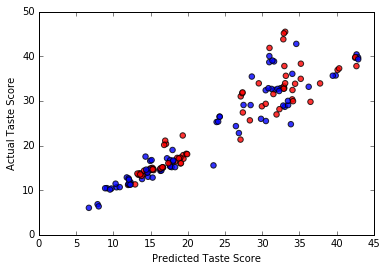

In [87]:
plt.scatter(clf3.predict(xTest), yTest, s=30, c=('b','r'), alpha=0.8)
plt.xlabel('Predicted Taste Score')
plt.ylabel('Actual Taste Score')